# **v1.0**

In [1]:
# import os
# os.chdir('/home/jovyan')

In [2]:
# %%capture
# !pip install imblearn
# !pip install --upgrade hyperopt==0.2.7
# !pip install --upgrade lightgbm==4.1.0
# !pip install --upgrade scipy==1.11.3
# !pip install --upgrade shap==0.43.0
# !pip install --upgrade gpboost==1.2.7.1

In [3]:
import pandas as pd
import numpy as np
import random
import warnings
from utils import *
from preprocessing.datasets import *
# from models import *
from model_utils import *

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 1000)
pd.set_option("display.max_colwidth", 50)

train_file = "results_train.txt"
test_file = "../../../Library/Containers/com.tencent.xinWeChat/Data/Library/Application Support/com.tencent.xinWeChat/2.0b4.0.9/8a68444d45fce6fe4c15b2eed305a648/Message/MessageTemp/8c15c62c4797ecf0455ebaaf9c9cfc9e/File/results_test.txt"

## **Pretreatment Stage**

### **Data preparation**

In [4]:
import json
clean_df = pd.read_csv('data/processed/clean_df.csv')

with open("data/processed/new_features.json", "r") as f:
    new_features = json.load(f)

good_quality_sids = []
with open("data/processed/good_quality_sids.txt", "r") as f:
    for line in f.readlines():
        good_quality_sids.append(line.split('\n')[0])
        
good_quality_sids = [sid for sid in good_quality_sids if sid in clean_df['sid'].values]  # check the existence

print(clean_df.shape)
print(len(new_features))

sw_df, final_features = split_data(clean_df, good_quality_sids, new_features)
sw_df
print(len(final_features))

(77528, 595)
582
354


### **Define random effect for GPBoost**

In [5]:
group_variables = ['AHI_Severity', 'Obesity']
# when idx == 0, it returns ['AHI_Severity'], the first variable in the list
# when idx == 1, it returns ['Obesity'], the second variable in the list

### **Split data to train, val, and test using "Apnea Severity" random effect**

In [6]:
random.seed(0) 
train_sids = random.sample(good_quality_sids, 56)
remaining_sids = [subj for subj in good_quality_sids if subj not in train_sids]
val_sids = random.sample(remaining_sids, 8)
test_sids = [subj for subj in remaining_sids if subj not in val_sids]

In [7]:
group_variable = get_variable(group_variables, idx = 0)
print("Current random effect:", group_variable)
print('')

X_train, y_train, group_train = train_test_split(sw_df, train_sids, final_features, group_variable)
print("Train data balance: ")
print(np.unique(y_train, return_counts=True))
print('')

X_val, y_val, group_val = train_test_split(sw_df, val_sids, final_features, group_variable)
print("Validation data balancpredicted_probabilitiese: ")
print(np.unique(y_val, return_counts=True))
print('')

X_test, y_test, group_test = train_test_split(sw_df, test_sids, final_features, group_variable)
print("Test data balance: ")
print(np.unique(y_test, return_counts=True))

Current random effect: ['AHI_Severity']

Train data balance: 
(array([0., 1.]), array([33209, 23595], dtype=int64))

Validation data balancpredicted_probabilitiese: 
(array([0., 1.]), array([5684, 2577], dtype=int64))

Test data balance: 
(array([0., 1.]), array([6987, 5476], dtype=int64))


### **Resample data**

In [8]:
X_train_resampled, y_train_resampled, group_train_resampled = resample_data(X_train, y_train, group_train, group_variable)
X_train_resampled

array([[ 8.74514453e+01,  2.67856258e+02,  2.77987500e+02, ...,
         1.28049440e+00, -7.25000000e+00,  0.00000000e+00],
       [ 8.46873043e+01,  2.80299933e+02,  2.31656250e+02, ...,
         1.15010516e+00,  6.75000000e+00,  1.00000000e+00],
       [ 9.08891847e+01,  2.24392912e+02,  2.08490625e+02, ...,
         2.84070154e-01, -5.00000000e+00,  1.00000000e+00],
       ...,
       [ 6.45810069e+01,  4.19736983e+02,  4.99149291e+02, ...,
         2.82940591e-01, -3.94747278e+00,  0.00000000e+00],
       [ 7.12413719e+01,  5.70312815e+01,  2.31656250e+01, ...,
         6.79723984e-01, -1.00067873e+01,  3.22263976e-01],
       [ 7.94706636e+01,  2.33197425e+02,  1.53903199e+02, ...,
        -1.74023928e-02, -9.61284490e-01,  0.00000000e+00]])

## **Training Stage**

### **KNN**

In [9]:
from yang_modelBuild.KNN_baseline import *
final_knn_model = KNN_engine(X_train_resampled, y_train_resampled, X_val, y_val)

100%|██████████| 50/50 [20:22<00:00, 24.45s/trial, best loss: -0.6034453922060546]
Best hyperparameters: {'metric': 'minkowski', 'n_neighbors': 48, 'weights': 'uniform'}


#### **Training score**

[[23842  9367]
 [ 6923 16672]]


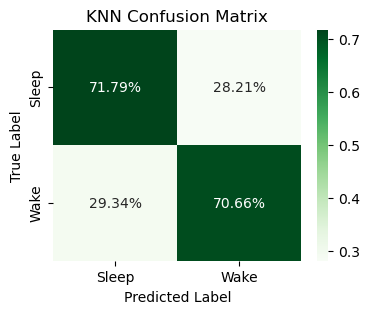

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,KNN,0.64027,0.70659,0.671798,0.717938,0.789819,0.728179,0.713224,0.400887


In [10]:
prob_list_train, len_train, true_list_train = compute_probabilities(
    train_sids, sw_df, final_features, 'KNN', final_knn_model, group_variable
)
pred_prob_train = get_predicted_probabilities('KNN', final_knn_model, X_train, group_train)
plot_cm(prob_list_train, true_list_train, 'KNN')
results_train_knn = get_evaluation_metrics("KNN", y_train, pred_prob_train, prob_list_train, true_list_train)
save_result(results_train_knn, train_file)
results_train_knn

#### **Testing score**

[[4629 2358]
 [1616 3860]]


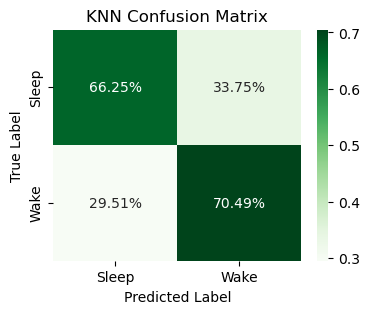

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,KNN,0.620778,0.704894,0.660168,0.662516,0.749979,0.681118,0.681136,0.383407


In [11]:
prob_list_test, len_test, true_list_test = compute_probabilities(
    test_sids, sw_df, final_features, 'KNN', final_knn_model, group_variable
)
pred_prob_test = get_predicted_probabilities('KNN', final_knn_model, X_test, group_test)
plot_cm(prob_list_test, true_list_test, 'KNN')
results_test_knn = get_evaluation_metrics("KNN", y_test, pred_prob_test, prob_list_test, true_list_test)
save_result(results_test_knn, test_file)
results_test_knn

### **DecisionTree**

In [12]:
from yang_modelBuild.DecisionTree_baseline import *
final_dt_model = DecisionTree_engine(X_train_resampled, y_train_resampled, X_val, y_val)

100%|██████████| 50/50 [38:57<00:00, 46.75s/trial, best loss: -0.8095037846930193] 
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 9}


#### **Training score**

[[30831  2378]
 [ 7233 16362]]


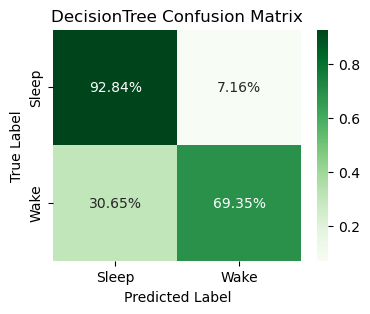

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,DecisionTree,0.873106,0.693452,0.772977,0.928393,0.899433,0.890385,0.830804,0.619046


In [13]:
prob_list_train, len_train, true_list_train = compute_probabilities(
    train_sids, sw_df, final_features, 'DT', final_dt_model, group_variable
)
pred_prob_train = get_predicted_probabilities('DT', final_dt_model, X_train, group_train)
plot_cm(prob_list_train, true_list_train, 'DecisionTree')
results_train_dt = get_evaluation_metrics("DecisionTree", y_train, pred_prob_train, prob_list_train, true_list_train)
save_result(results_train_dt, train_file)
results_train_dt

#### **Testing score**

[[5843 1144]
 [1631 3845]]


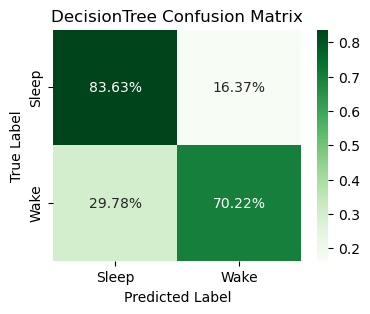

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,DecisionTree,0.770696,0.702155,0.73483,0.836267,0.848821,0.834617,0.777341,0.521593


In [14]:
prob_list_test, len_test, true_list_test = compute_probabilities(
    test_sids, sw_df, final_features, 'DT', final_dt_model, group_variable
)
pred_prob_test = get_predicted_probabilities('DT', final_dt_model, X_test, group_test)
plot_cm(prob_list_test, true_list_test, 'DecisionTree')
results_test_dt = get_evaluation_metrics("DecisionTree", y_test, pred_prob_test, prob_list_test, true_list_test)
save_result(results_test_dt, test_file)
results_test_dt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


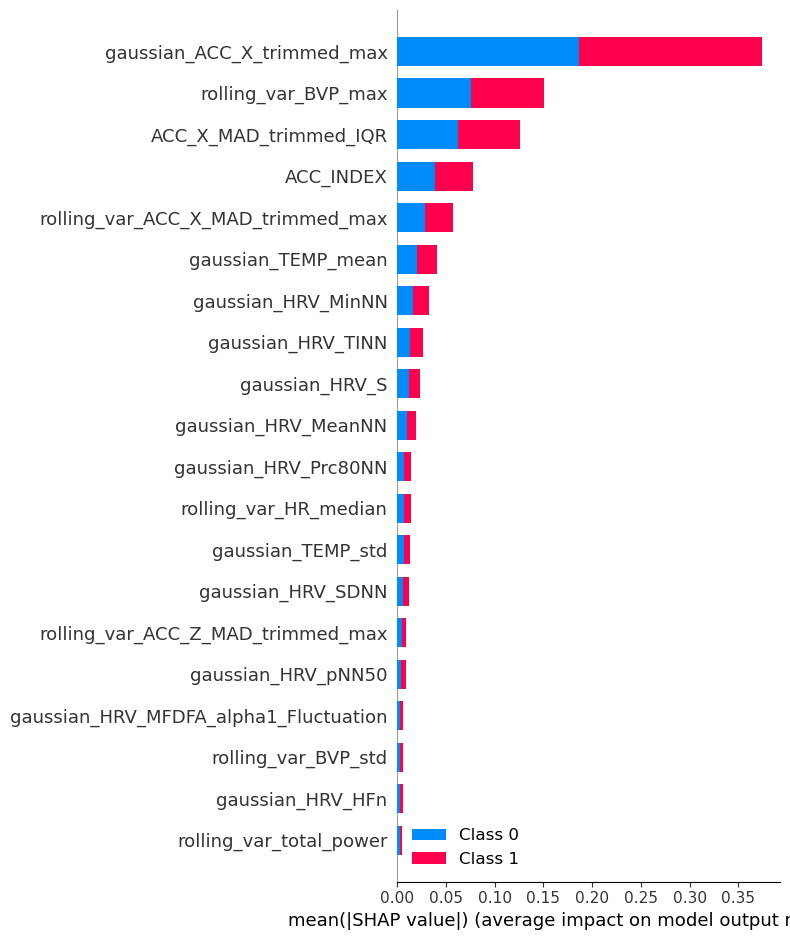

In [15]:
# 决策树可视化
import shap

explainer = shap.TreeExplainer(final_dt_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=final_features)

### **Random Forest**

In [16]:
from dream_models.dream_random_forest_baseline import *
rf = rf_trainer(X_train_resampled, y_train_resampled, X_val, y_val)

 82%|████████▏ | 41/50 [59:51<13:08, 87.59s/trial, best loss: -0.8043521266073195]   
Best Hyperparameters of RandomForest: {'bootstrap': 1, 'criterion': 0, 'max_depth': 10, 'max_features': 0, 'min_samples_leaf': 0.02732445513580169, 'min_samples_split': 0.15064991865129912, 'n_estimators': 359}


#### **Training score**

[[28525  4684]
 [ 5948 17647]]


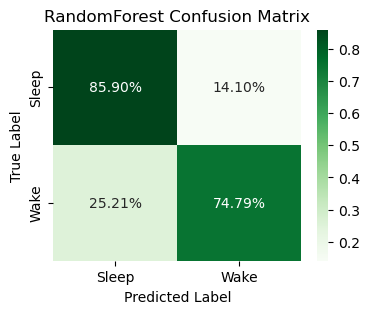

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,RandomForest,0.790247,0.747913,0.768497,0.858954,0.893495,0.882528,0.81283,0.592639


In [17]:
prob_list_train, len_train, true_list_train = compute_probabilities(
    train_sids, sw_df, final_features, 'rf', rf, group_variable
)
pred_prob_train = get_predicted_probabilities('rf', rf, X_train, group_train)
plot_cm(prob_list_train, true_list_train, 'RandomForest')
results_train_rf = get_evaluation_metrics("RandomForest", y_train, pred_prob_train, prob_list_train, true_list_train)
save_result(results_train_rf, train_file)
results_train_rf

#### **Testing score**

[[5487 1500]
 [1215 4261]]


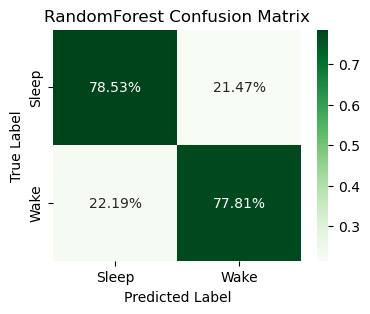

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,RandomForest,0.739629,0.778123,0.758387,0.785316,0.867829,0.848683,0.782155,0.539293


In [18]:
prob_list_test, len_test, true_list_test = compute_probabilities(
    test_sids, sw_df, final_features, 'rf', rf, group_variable
)
pred_prob_test = get_predicted_probabilities('rf', rf, X_test, group_test)
plot_cm(prob_list_test, true_list_test, 'RandomForest')
results_test_rf = get_evaluation_metrics("RandomForest", y_test, pred_prob_test, prob_list_test, true_list_test)
save_result(results_test_rf, test_file)
results_test_rf

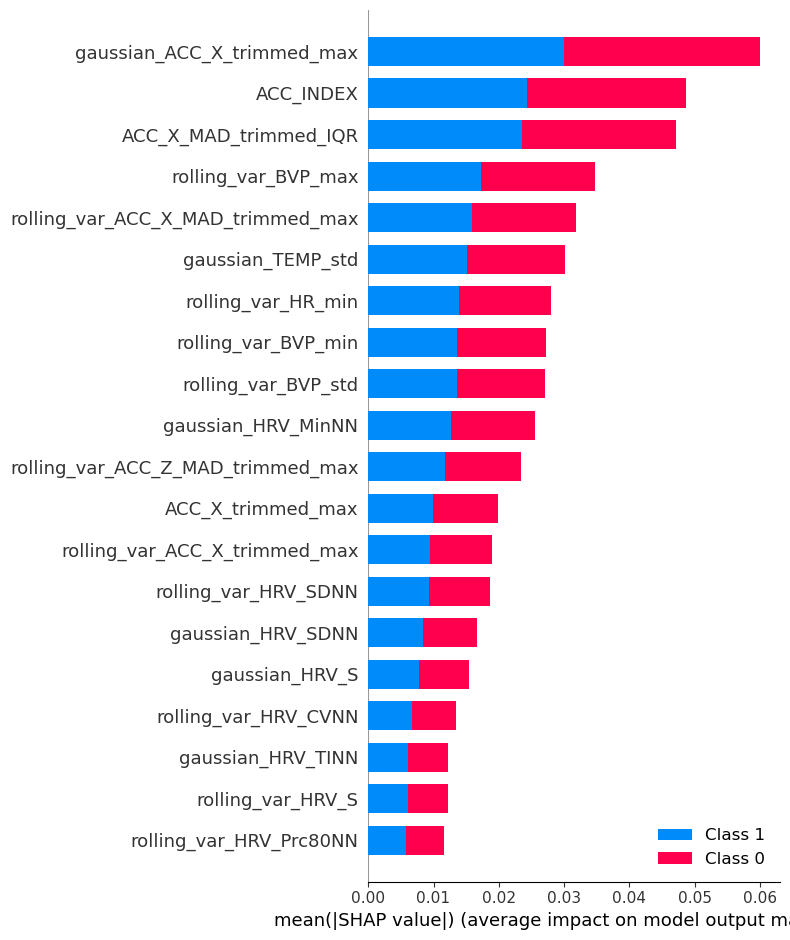

In [19]:
# 随机森林可视化
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=final_features)

### **LightGBM**

#### **Initial Prediction with LightGBM along with filtering features**

In [20]:
from dream_models.dream_lightgbm import *
lgbm = lightgbm_trainer(X_train_resampled, y_train_resampled, X_val, y_val)

[LightGBM] [Info] Number of positive: 33209, number of negative: 33209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90221                    
[LightGBM] [Info] Number of data points in the train set: 66418, number of used features: 354
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 33209, number of negative: 33209          
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90221                                              
[LightGBM] [Info] Number of data points in the train set: 66418, number of used features: 354
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000  
[LightGBM] [Warning] No further splits w

#### **Training score**

[[30788  2421]
 [ 3390 20205]]


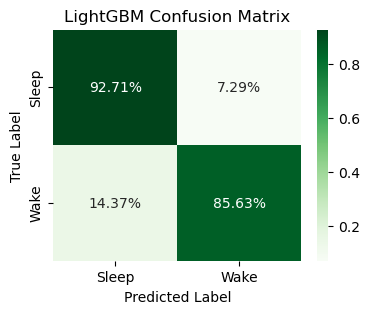

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,LightGBM,0.892999,0.856325,0.874278,0.927098,0.960633,0.953642,0.897701,0.757702


In [21]:
prob_list_train, len_train, true_list_train = compute_probabilities(
    train_sids, sw_df, final_features, 'lgb', lgbm, group_variable
)
pred_prob_train = get_predicted_probabilities('lgb', lgbm, X_train, group_train)
plot_cm(prob_list_train, true_list_train, 'LightGBM')
results_train_lgbm = get_evaluation_metrics("LightGBM", y_train, pred_prob_train, prob_list_train, true_list_train)
save_result(results_train_lgbm, train_file)
results_train_lgbm

#### **Testing score**

[[5326 1661]
 [ 838 4638]]


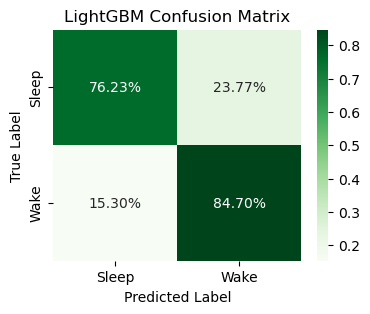

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,LightGBM,0.736307,0.846969,0.787771,0.762273,0.890413,0.872859,0.799486,0.574165


In [22]:
prob_list_test, len_test, true_list_test = compute_probabilities(
    test_sids, sw_df, final_features, 'lgb', lgbm, group_variable
)
pred_prob_test = get_predicted_probabilities('lgb', lgbm, X_test, group_test)
plot_cm(prob_list_test, true_list_test, 'LightGBM')
results_test_lgbm = get_evaluation_metrics("LightGBM", y_test, pred_prob_test, prob_list_test, true_list_test)
save_result(results_test_lgbm, test_file)
results_test_lgbm

#### **Identify the best features by explaining the model using `shap` library:**

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


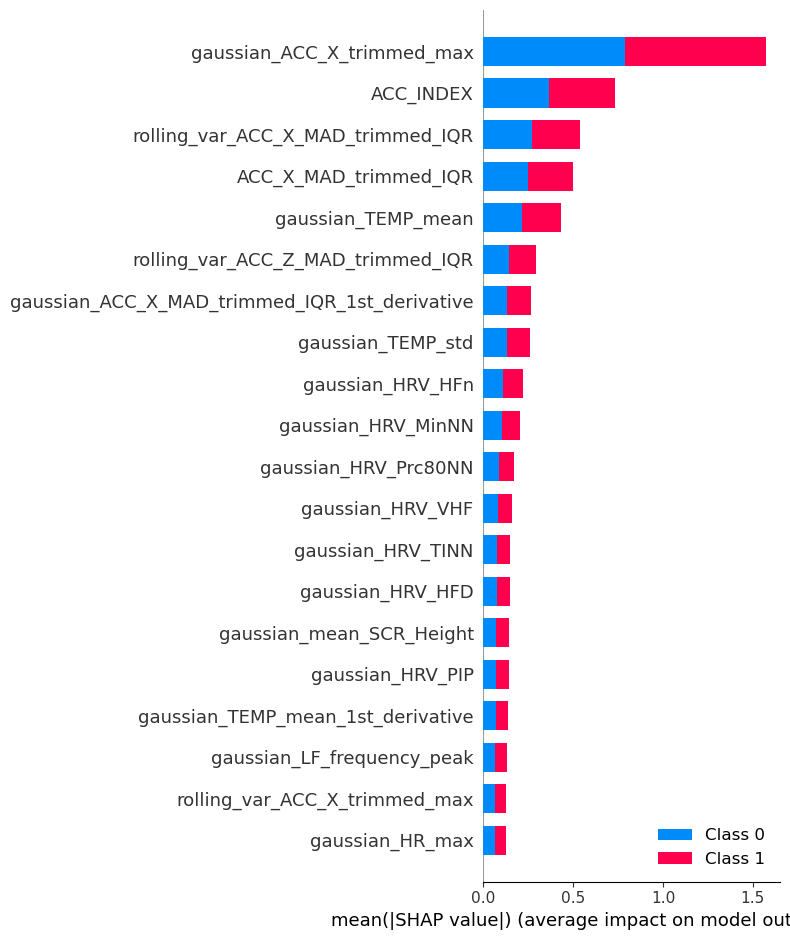

In [23]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=final_features)

### **LightGBM + LSTM post-processing**

In [24]:
import torch
from dream_models.dream_lstm import *

#### **Training process:**

In [25]:
train_dataset = TimeSeriesDataset(prob_list_train, len_train, true_list_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [26]:
lstm = lstm_trainer(train_dataloader, num_epoch=300, hidden_layer_size=32, learning_rate=1e-3)

Current device: cuda:0
Epoch 5 / 300 - Loss: 0.6815, Accuracy: 0.7791
Epoch 10 / 300 - Loss: 0.6314, Accuracy: 0.5153
Epoch 15 / 300 - Loss: 0.5697, Accuracy: 0.5197
Epoch 20 / 300 - Loss: 0.4369, Accuracy: 0.7778
Epoch 25 / 300 - Loss: 0.3477, Accuracy: 0.7853
Epoch 30 / 300 - Loss: 0.3189, Accuracy: 0.7905
Epoch 35 / 300 - Loss: 0.3049, Accuracy: 0.7932
Epoch 40 / 300 - Loss: 0.2951, Accuracy: 0.7923
Epoch 45 / 300 - Loss: 0.2908, Accuracy: 0.7925
Epoch 50 / 300 - Loss: 0.2876, Accuracy: 0.7924
Epoch 55 / 300 - Loss: 0.2853, Accuracy: 0.7925
Epoch 60 / 300 - Loss: 0.2831, Accuracy: 0.7929
Epoch 65 / 300 - Loss: 0.2811, Accuracy: 0.7930
Epoch 70 / 300 - Loss: 0.2791, Accuracy: 0.7929
Epoch 75 / 300 - Loss: 0.2771, Accuracy: 0.7925
Epoch 80 / 300 - Loss: 0.2750, Accuracy: 0.9185
Epoch 85 / 300 - Loss: 0.2727, Accuracy: 0.9187
Epoch 90 / 300 - Loss: 0.2702, Accuracy: 0.9200
Epoch 95 / 300 - Loss: 0.2686, Accuracy: 0.9206
Epoch 100 / 300 - Loss: 0.2669, Accuracy: 0.9202
Epoch 105 / 300 -

#### **Evaluation with test set:**

In [27]:
test_dataset = TimeSeriesDataset(prob_list_test, len_test, true_list_test)
test_dataloader = DataLoader(test_dataset, batch_size=1)

Current device: cuda:0
[[5604 1383]
 [ 650 4826]]


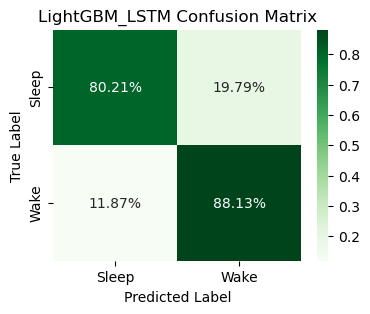

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,LightGBM_LSTM,0.777259,0.8813,0.826016,0.802061,0.901933,0.86604,0.836877,0.652956


In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Current device: {device}")

lstm.eval()
lstm.to(device)

pred_prob = []
kappa = []

with torch.no_grad():
    for batch in test_dataloader:
        sample = batch['sample'].to(device)
        length = batch['length']
        label = batch['label'].to(device)

        outputs = lstm(sample, length)

        pred_prob.extend(outputs.cpu().numpy())

        kappa.append(
            cohen_kappa_score(
                label.cpu().numpy()[0],
                np.argmax(outputs.cpu().numpy()[0], axis=1)
            )
        )

true_arr = np.concatenate(true_list_test)
pred_arr = np.concatenate(pred_prob)

results_test_lgbm_lstm = calculate_metrics(true_arr, pred_arr, 'LightGBM_LSTM')
results_test_lgbm_lstm["Cohen's Kappa"] = np.average(kappa)

plot_cm(pred_arr, true_list_test, 'LightGBM_LSTM')
save_result(results_test_lgbm_lstm, test_file)
results_test_lgbm_lstm

### **GPBoost + Apnea Severity random effect**

In [29]:
from yang_modelBuild.GPBoost import *
final_gpb_model = GPBoost_engine(X_train_resampled, group_train_resampled, y_train_resampled, X_val, y_val, group_val)

100%|██████████| 50/50 [41:53<00:00, 50.27s/trial, best loss: -0.8276803118908382]
Best hyperparameters: {'feature_fraction': 0.9238789237141506, 'lambda_l1': 70.0, 'lambda_l2': 9.78578617650293, 'learning_rate': 0.007944789548493049, 'max_depth': 6.0, 'neg_bagging_fraction': 0.6289545326792014, 'num_boost_round': 1000.0, 'num_leaves': 160.0, 'pos_bagging_fraction': 0.889268294164729}


Found `num_boost_round` in params. Will use it instead of argument


[GPBoost] [Info] Total Bins 90221
[GPBoost] [Info] Number of data points in the train set: 66418, number of used features: 354
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=3.843570
[GPBoost] [Info] Start training from score 3.843570
[1]	valid_0's test_neg_log_likelihood: 0.667824
[2]	valid_0's test_neg_log_likelihood: 0.665633
[3]	valid_0's test_neg_log_likelihood: 0.663458
[4]	valid_0's test_neg_log_likelihood: 0.661318
[5]	valid_0's test_neg_log_likelihood: 0.659165
[6]	valid_0's test_neg_log_likelihood: 0.657079
[7]	valid_0's test_neg_log_likelihood: 0.655007
[8]	valid_0's test_neg_log_likelihood: 0.652902
[9]	valid_0's test_neg_log_likelihood: 0.650827
[10]	valid_0's test_neg_log_likelihood: 0.648785
[11]	valid_0's test_neg_log_likelihood: 0.646733
[12]	valid_0's test_neg_log_likelihood: 0.64471
[13]	valid_0's test_neg_log_likelihood: 0.642726
[14]	valid_0's test_neg_log_likelihood: 0.640746
[15]	valid_0's test_neg_log_likelihood: 0.638711
[16]	valid_0's t

#### **Training score**

[[30890  2319]
 [ 4326 19269]]


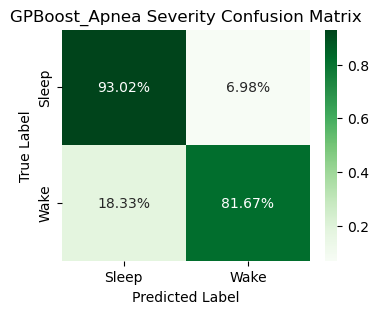

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,GPBoost_Apnea Severity,0.892579,0.816656,0.852931,0.93017,0.949914,0.941911,0.883019,0.724877


In [30]:
prob_list_train, len_train, true_list_train = compute_probabilities(
    train_sids, sw_df, final_features, 'gpb', final_gpb_model, group_variable
)
pred_prob_train = get_predicted_probabilities('gpb', final_gpb_model, X_train, group_train)
plot_cm(prob_list_train, true_list_train, 'GPBoost_Apnea Severity')
results_train_gpb_Apnea = get_evaluation_metrics("GPBoost_Apnea Severity", y_train, pred_prob_train, prob_list_train, true_list_train)
save_result(results_train_gpb_Apnea, train_file)
results_train_gpb_Apnea

#### **Testing score**

[[5479 1508]
 [1027 4449]]


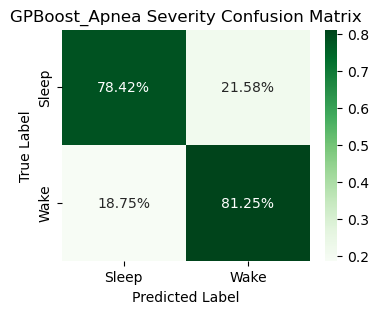

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,GPBoost_Apnea Severity,0.746852,0.812454,0.778273,0.784171,0.885969,0.865473,0.796598,0.567031


In [31]:
prob_list_test, len_test, true_list_test = compute_probabilities(
    test_sids, sw_df, final_features, 'gpb', final_gpb_model, group_variable
)
pred_prob_test = get_predicted_probabilities('gpb', final_gpb_model, X_test, group_test)
plot_cm(prob_list_test, true_list_test, 'GPBoost_Apnea Severity')
results_test_gpb_Apnea = get_evaluation_metrics("GPBoost_Apnea Severity", y_test, pred_prob_test, prob_list_test, true_list_test)
save_result(results_test_gpb_Apnea, test_file)
results_test_gpb_Apnea

### **GPBoost + Apnea Severity random effect + LSTM post-processing**

#### **Training process:**

In [32]:
train_dataset = TimeSeriesDataset(prob_list_train, len_train, true_list_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [33]:
import torch
from dream_models.dream_lstm import *
lstm = lstm_trainer(train_dataloader, num_epoch=300, hidden_layer_size=32, learning_rate=1e-3)

Current device: cuda:0
Epoch 5 / 300 - Loss: 0.6615, Accuracy: 0.5154
Epoch 10 / 300 - Loss: 0.6189, Accuracy: 0.5153
Epoch 15 / 300 - Loss: 0.5389, Accuracy: 0.7019
Epoch 20 / 300 - Loss: 0.3861, Accuracy: 0.7810
Epoch 25 / 300 - Loss: 0.3497, Accuracy: 0.7708
Epoch 30 / 300 - Loss: 0.3276, Accuracy: 0.7797
Epoch 35 / 300 - Loss: 0.3156, Accuracy: 0.7850
Epoch 40 / 300 - Loss: 0.3085, Accuracy: 0.9114
Epoch 45 / 300 - Loss: 0.3037, Accuracy: 0.9118
Epoch 50 / 300 - Loss: 0.2996, Accuracy: 0.9126
Epoch 55 / 300 - Loss: 0.2966, Accuracy: 0.9124
Epoch 60 / 300 - Loss: 0.2941, Accuracy: 0.9127
Epoch 65 / 300 - Loss: 0.2917, Accuracy: 0.9129
Epoch 70 / 300 - Loss: 0.2895, Accuracy: 0.9130
Epoch 75 / 300 - Loss: 0.2874, Accuracy: 0.9131
Epoch 80 / 300 - Loss: 0.2853, Accuracy: 0.9128
Epoch 85 / 300 - Loss: 0.2833, Accuracy: 0.9128
Epoch 90 / 300 - Loss: 0.2816, Accuracy: 0.9129
Epoch 95 / 300 - Loss: 0.2799, Accuracy: 0.9129
Epoch 100 / 300 - Loss: 0.2782, Accuracy: 0.9129
Epoch 105 / 300 -

#### **Evaluation with test set:**

In [34]:
test_dataset = TimeSeriesDataset(prob_list_test, len_test, true_list_test)
test_dataloader = DataLoader(test_dataset, batch_size=1)

Current device: cuda:0
[[5462 1525]
 [ 719 4757]]


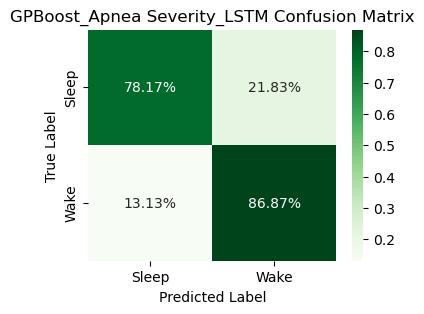

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,GPBoost_Apnea Severity_LSTM,0.757243,0.8687,0.809151,0.781738,0.898068,0.872218,0.819947,0.617549


In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Current device: {device}")

lstm.eval()
lstm.to(device)

pred_prob = []
kappa = []

with torch.no_grad():
    for batch in test_dataloader:
        sample = batch['sample'].to(device)
        length = batch['length']
        label = batch['label'].to(device)

        outputs = lstm(sample, length)

        pred_prob.extend(outputs.cpu().numpy())

        kappa.append(
            cohen_kappa_score(
                label.cpu().numpy()[0],
                np.argmax(outputs.cpu().numpy()[0], axis=1)
            )
        )

true_arr = np.concatenate(true_list_test)
pred_arr = np.concatenate(pred_prob)

results_test_gpb_Apnea_lstm = calculate_metrics(true_arr, pred_arr, 'GPBoost_Apnea Severity_LSTM')
results_test_gpb_Apnea_lstm["Cohen's Kappa"] = np.average(kappa)

plot_cm(pred_arr, true_list_test, 'GPBoost_Apnea Severity_LSTM')

save_result(results_test_gpb_Apnea_lstm, test_file)
results_test_gpb_Apnea_lstm

### **GPBoost + Obesity random effect**

#### **Split data to train, val, and test using "Obesity" random effect**

In [36]:
group_variable = get_variable(group_variables, idx = 1)
print("Current random effect:", group_variable)
print('')

X_train, y_train, group_train = train_test_split(sw_df, train_sids, final_features, group_variable)
print("Train data balance: ")
print(np.unique(y_train, return_counts=True))
print('')

X_val, y_val, group_val = train_test_split(sw_df, val_sids, final_features, group_variable)
print("Validation data balancpredicted_probabilitiese: ")
print(np.unique(y_val, return_counts=True))
print('')

X_test, y_test, group_test = train_test_split(sw_df, test_sids, final_features, group_variable)
print("Test data balance: ")
print(np.unique(y_test, return_counts=True))

Current random effect: ['Obesity']

Train data balance: 
(array([0., 1.]), array([33209, 23595], dtype=int64))

Validation data balancpredicted_probabilitiese: 
(array([0., 1.]), array([5684, 2577], dtype=int64))

Test data balance: 
(array([0., 1.]), array([6987, 5476], dtype=int64))


#### **Resample data**

In [37]:
X_train_resampled, y_train_resampled, group_train_resampled = resample_data(X_train, y_train, group_train, group_variable)
X_train_resampled

array([[ 8.74514453e+01,  2.67856258e+02,  2.77987500e+02, ...,
         1.28049440e+00, -7.25000000e+00,  0.00000000e+00],
       [ 8.46873043e+01,  2.80299933e+02,  2.31656250e+02, ...,
         1.15010516e+00,  6.75000000e+00,  1.00000000e+00],
       [ 9.08891847e+01,  2.24392912e+02,  2.08490625e+02, ...,
         2.84070154e-01, -5.00000000e+00,  1.00000000e+00],
       ...,
       [ 6.45810069e+01,  4.19736983e+02,  4.99149291e+02, ...,
         2.82940591e-01, -3.94747278e+00,  0.00000000e+00],
       [ 7.12413719e+01,  5.70312815e+01,  2.31656250e+01, ...,
         6.79723984e-01, -1.00067873e+01,  3.22263976e-01],
       [ 7.94706636e+01,  2.33197425e+02,  1.53903199e+02, ...,
        -1.74023928e-02, -9.61284490e-01,  0.00000000e+00]])

#### **Build model**

In [38]:
from yang_modelBuild.GPBoost import *
final_gpb_model = GPBoost_engine(X_train_resampled, group_train_resampled, y_train_resampled, X_val, y_val, group_val)

100%|██████████| 50/50 [37:38<00:00, 45.17s/trial, best loss: -0.853796603552606] 
Best hyperparameters: {'feature_fraction': 0.5082000564488496, 'lambda_l1': 60.0, 'lambda_l2': 1.1943585404002741, 'learning_rate': 0.009928484639669027, 'max_depth': 6.0, 'neg_bagging_fraction': 0.7973518964594606, 'num_boost_round': 1000.0, 'num_leaves': 160.0, 'pos_bagging_fraction': 0.9063550825622663}


Found `num_boost_round` in params. Will use it instead of argument


[GPBoost] [Info] Total Bins 90221
[GPBoost] [Info] Number of data points in the train set: 66418, number of used features: 354
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=3.947606
[GPBoost] [Info] Start training from score 3.947606
[1]	valid_0's test_neg_log_likelihood: 0.66901
[2]	valid_0's test_neg_log_likelihood: 0.666218
[3]	valid_0's test_neg_log_likelihood: 0.663312
[4]	valid_0's test_neg_log_likelihood: 0.660501
[5]	valid_0's test_neg_log_likelihood: 0.657598
[6]	valid_0's test_neg_log_likelihood: 0.655035
[7]	valid_0's test_neg_log_likelihood: 0.652397
[8]	valid_0's test_neg_log_likelihood: 0.649626
[9]	valid_0's test_neg_log_likelihood: 0.647143
[10]	valid_0's test_neg_log_likelihood: 0.644439
[11]	valid_0's test_neg_log_likelihood: 0.641671
[12]	valid_0's test_neg_log_likelihood: 0.639213
[13]	valid_0's test_neg_log_likelihood: 0.636658
[14]	valid_0's test_neg_log_likelihood: 0.634045
[15]	valid_0's test_neg_log_likelihood: 0.631484
[16]	valid_0's t

#### **Training score**

[[30817  2392]
 [ 3876 19719]]


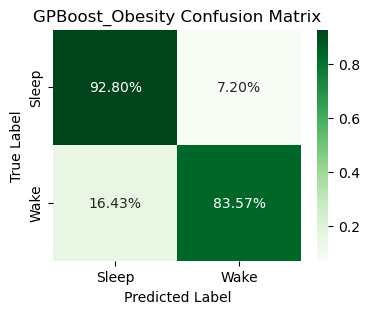

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,GPBoost_Obesity,0.891819,0.835728,0.862863,0.927971,0.956173,0.947927,0.889656,0.741395


In [39]:
prob_list_train, len_train, true_list_train = compute_probabilities(
    train_sids, sw_df, final_features, 'gpb', final_gpb_model, group_variable
)
pred_prob_train = get_predicted_probabilities('gpb', final_gpb_model, X_train, group_train)
plot_cm(prob_list_train, true_list_train, 'GPBoost_Obesity')
results_train_gpb_Obesity = get_evaluation_metrics("GPBoost_Obesity", y_train, pred_prob_train, prob_list_train, true_list_train)
save_result(results_train_gpb_Obesity, train_file)
results_train_gpb_Obesity

#### **Testing score**

[[5566 1421]
 [ 949 4527]]


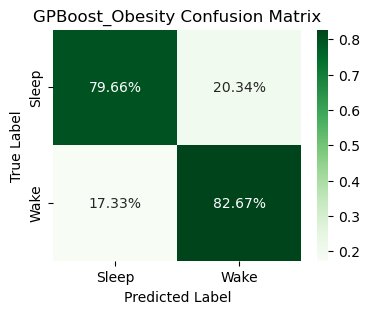

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,GPBoost_Obesity,0.761096,0.826698,0.792542,0.796622,0.895033,0.878363,0.809837,0.590392


In [40]:
prob_list_test, len_test, true_list_test = compute_probabilities(
    test_sids, sw_df, final_features, 'gpb', final_gpb_model, group_variable
)
pred_prob_test = get_predicted_probabilities('gpb', final_gpb_model, X_test, group_test)
plot_cm(prob_list_test, true_list_test, 'GPBoost_Obesity')
results_test_gpb_Obesity = get_evaluation_metrics("GPBoost_Obesity", y_test, pred_prob_test, prob_list_test, true_list_test)
save_result(results_test_gpb_Obesity, test_file)
results_test_gpb_Obesity

### **GPBoost + Obesity random effect + LSTM post-processing**

#### **Training process:**

In [41]:
train_dataset = TimeSeriesDataset(prob_list_train, len_train, true_list_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [42]:
lstm = lstm_trainer(train_dataloader, num_epoch=300, hidden_layer_size=32, learning_rate=1e-3)

Current device: cuda:0
Epoch 5 / 300 - Loss: 0.6554, Accuracy: 0.5154
Epoch 10 / 300 - Loss: 0.6174, Accuracy: 0.5154
Epoch 15 / 300 - Loss: 0.5489, Accuracy: 0.7027
Epoch 20 / 300 - Loss: 0.4025, Accuracy: 0.7791
Epoch 25 / 300 - Loss: 0.3399, Accuracy: 0.9052
Epoch 30 / 300 - Loss: 0.3132, Accuracy: 0.9129
Epoch 35 / 300 - Loss: 0.3026, Accuracy: 0.9146
Epoch 40 / 300 - Loss: 0.2945, Accuracy: 0.9153
Epoch 45 / 300 - Loss: 0.2894, Accuracy: 0.9150
Epoch 50 / 300 - Loss: 0.2854, Accuracy: 0.9153
Epoch 55 / 300 - Loss: 0.2827, Accuracy: 0.9158
Epoch 60 / 300 - Loss: 0.2802, Accuracy: 0.9161
Epoch 65 / 300 - Loss: 0.2781, Accuracy: 0.9162
Epoch 70 / 300 - Loss: 0.2763, Accuracy: 0.9162
Epoch 75 / 300 - Loss: 0.2745, Accuracy: 0.9164
Epoch 80 / 300 - Loss: 0.2729, Accuracy: 0.9163
Epoch 85 / 300 - Loss: 0.2713, Accuracy: 0.9163
Epoch 90 / 300 - Loss: 0.2697, Accuracy: 0.9165
Epoch 95 / 300 - Loss: 0.2682, Accuracy: 0.9165
Epoch 100 / 300 - Loss: 0.2667, Accuracy: 0.9165
Epoch 105 / 300 -

#### **Evaluation with test set:**

In [43]:
test_dataset = TimeSeriesDataset(prob_list_test, len_test, true_list_test)
test_dataloader = DataLoader(test_dataset, batch_size=1)

Current device: cuda:0
[[5598 1389]
 [ 532 4944]]


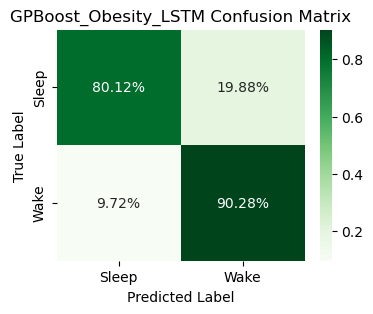

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,GPBoost_Obesity_LSTM,0.780673,0.902849,0.837327,0.801202,0.912599,0.885317,0.845864,0.671079


In [44]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Current device: {device}")

lstm.eval()
lstm.to(device)

pred_prob = []
kappa = []

with torch.no_grad():
    for batch in test_dataloader:
        sample = batch['sample'].to(device)
        length = batch['length']
        label = batch['label'].to(device)

        outputs = lstm(sample, length)

        pred_prob.extend(outputs.cpu().numpy())

        kappa.append(
            cohen_kappa_score(
                label.cpu().numpy()[0],
                np.argmax(outputs.cpu().numpy()[0], axis=1)
            )
        )

true_arr = np.concatenate(true_list_test)
pred_arr = np.concatenate(pred_prob)

results_test_gpb_Obesity_lstm = calculate_metrics(true_arr, pred_arr, 'GPBoost_Obesity_LSTM')
results_test_gpb_Obesity_lstm["Cohen's Kappa"] = np.average(kappa)

plot_cm(pred_arr, true_list_test, 'GPBoost_Obesity_LSTM')

save_result(results_test_gpb_Obesity_lstm, test_file)
results_test_gpb_Obesity_lstm